In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

print(sys.version_info)
for module in mpl, np, pd, sklearn, torch:
    print(module.__name__, module.__version__)

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


sys.version_info(major=3, minor=10, micro=14, releaselevel='final', serial=0)
matplotlib 3.10.0
numpy 1.26.4
pandas 2.2.3
sklearn 1.6.0
torch 2.5.1+cu124
cuda:0


# 数据加载

In [2]:
import unicodedata
import re
from sklearn.model_selection import train_test_split

#因为西班牙语有一些是特殊字符，所以我们需要unicode转ascii，
# 这样值变小了，因为unicode太大
def unicode_to_ascii(s):
    #NFD是转换方法，把每一个字节拆开，Mn是重音，所以去除
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

#下面我们找个样本测试一下
# 加u代表对字符串进行unicode编码
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"

print(unicode_to_ascii(en_sentence))
print(unicode_to_ascii(sp_sentence))




May I borrow this book?
¿Puedo tomar prestado este libro?


In [3]:
def preprocess_sentence(w):
    #变为小写，去掉多余的空格，变成小写，id少一些
    w = unicode_to_ascii(w.lower().strip())

    # 在单词与跟在其后的标点符号之间插入一个空格
    # eg: "he is a boy." => "he is a boy . "
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    #因为可能有多余空格，替换为一个空格，所以处理一下
    w = re.sub(r'[" "]+', " ", w)

    # 除了 (a-z, A-Z, ".", "?", "!", ",")，将所有字符替换为空格，你可以保留一些标点符号
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    return w

print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))  #¿是占用两个字节的

may i borrow this book ?
¿ puedo tomar prestado este libro ?
b'\xc2\xbf puedo tomar prestado este libro ?'


# Dataset

In [4]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

class LangPairDataset(Dataset):
    fpath = Path(r"./spa.txt") #数据文件路径
    cache_path = Path(r"./.cache/lang_pair.npy") #缓存文件路径
    split_index = np.random.choice(a=["train", "test"], replace=True, p=[0.9, 0.1], size=118964) #按照9:1划分训练集和测试集
    def __init__(self, mode="train", cache=False):
        if cache or not self.cache_path.exists():#如果没有缓存，或者缓存不存在，就处理一下数据
            self.cache_path.parent.mkdir(parents=True, exist_ok=True) #创建缓存文件夹，如果存在就忽略
            with open(self.fpath, "r", encoding="utf8") as file:
                lines = file.readlines()
                lang_pair = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines] #处理数据，变成list((trg, src))的形式
                trg, src = zip(*lang_pair) #分离出目标语言和源语言
                trg=np.array(trg) #转换为numpy数组
                src=np.array(src) #转换为numpy数组
                np.save(self.cache_path, {"trg": trg, "src": src})  #保存为npy文件,方便下次直接读取,不用再处理
        else:
            lang_pair = np.load(self.cache_path, allow_pickle=True).item() #读取npy文件，allow_pickle=True允许读取字典
            trg = lang_pair["trg"]
            src = lang_pair["src"]

        self.trg = trg[self.split_index == mode] #按照index拿到训练集的 标签语言 --英语
        self.src = src[self.split_index == mode] #按照index拿到训练集的源语言 --西班牙

    def __getitem__(self, index):
        return self.src[index], self.trg[index]

    def __len__(self):
        return len(self.src)


train_ds = LangPairDataset("train")
test_ds = LangPairDataset("test")

In [5]:
print("source: {}\ntarget: {}".format(*train_ds[-1]))

source: si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado .
target: if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo .


# Tokenizer

In [6]:
from collections import Counter

def get_word_idx(ds, mode="src", threshold=2):
    #载入词表，看下词表长度，词表就像英语字典
    word2idx = {
        "[PAD]": 0,     # 填充 token
        "[BOS]": 1,     # begin of sentence
        "[UNK]": 2,     # 未知 token
        "[EOS]": 3,     # end of sentence
    }
    idx2word = {value: key for key, value in word2idx.items()}
    index = len(idx2word)
    threshold = 1  # 出现次数低于此的token舍弃
    #如果数据集有很多个G，那是用for循环的，不能' '.join
    word_list = " ".join([pair[0 if mode=="src" else 1] for pair in ds]).split()
    counter = Counter(word_list) #统计词频,counter类似字典，key是单词，value是出现次数
    print("word count:", len(counter))

    for token, count in counter.items():
        if count >= threshold:#出现次数大于阈值的token加入词表
            word2idx[token] = index #加入词表
            idx2word[index] = token #加入反向词表
            index += 1

    return word2idx, idx2word

src_word2idx, src_idx2word = get_word_idx(train_ds, "src") #源语言词表
trg_word2idx, trg_idx2word = get_word_idx(train_ds, "trg") #目标语言词表

word count: 23774
word count: 12465


In [7]:
class Tokenizer:
    def __init__(self, word2idx, idx2word, max_length=500, pad_idx=0, bos_idx=1, eos_idx=3, unk_idx=2):
        """
        初始化分词器
        Args:
            word2idx (dict): 词到索引的映射字典
            idx2word (dict): 索引到词的映射字典
            max_length (int): 序列最大长度限制（默认500）
            pad_idx (int): 填充符的索引（默认0）
            bos_idx (int): 起始符的索引（默认1）
            eos_idx (int): 结束符的索引（默认3）
            unk_idx (int): 未知词的索引（默认2）
        """
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.max_length = max_length  # 序列最大长度限制
        self.pad_idx = pad_idx       # 填充符
        self.bos_idx = bos_idx       # 起始符（Begin of Sequence）
        self.eos_idx = eos_idx       # 结束符（End of Sequence）
        self.unk_idx = unk_idx       # 未知词（Unknown Token）

    def encode(self, text_list, padding_first=False, add_bos=True, add_eos=True, return_mask=False):
        """
        将文本列表编码为索引序列
        Args:
            text_list: 二维列表，每个元素是一个文本的词列表（如 [["hello"], ["hello", "world"]])
            padding_first: 是否在前面填充（默认False，在后面填充）
            add_bos: 是否添加起始符（默认True）
            add_eos: 是否添加结束符（默认True）
            return_mask: 是否返回掩码矩阵（默认False）
        Returns:
            input_ids: 编码后的索引矩阵（Tensor）
            masks: 掩码矩阵（可选返回，1表示填充位置）
        """
        # 计算有效最大长度（考虑BOS/EOS）
        max_length = min(
            self.max_length,
            add_eos + add_bos + max([len(text) for text in text_list])  # 实际内容的最大长度
        )
        
        indices_list = []
        for text in text_list:
            # 1. 截断文本并转换为索引
            indices = [
                self.word2idx.get(word, self.unk_idx)  # 未登录词用UNK代替
                for word in text[:max_length - add_bos - add_eos]  # 截断超长部分
            ]
            
            # 2. 添加特殊符号
            if add_bos:
                indices = [self.bos_idx] + indices  # 开头加BOS
            if add_eos:
                indices = indices + [self.eos_idx]  # 末尾加EOS
                
            # 3. 填充处理
            padding_length = max_length - len(indices)
            if padding_first:  # 前面填充
                indices = [self.pad_idx] * padding_length + indices
            else:  # 后面填充（默认）
                indices = indices + [self.pad_idx] * padding_length
            
            indices_list.append(indices)
        
        # 转换为Tensor
        input_ids = torch.tensor(indices_list)
        # 生成掩码（1表示填充位置）
        masks = (input_ids == self.pad_idx).to(dtype=torch.int64)
        
        return input_ids if not return_mask else (input_ids, masks)

    def decode(self, indices_list, remove_bos=True, remove_eos=True, remove_pad=True, split=False):
        """
        将索引序列解码回文本
        Args:
            indices_list: 索引序列（可以是Tensor或列表）
            remove_bos: 是否移除起始符（默认True）
            remove_eos: 是否遇到结束符停止解码（默认True）
            remove_pad: 是否遇到填充符停止解码（默认True）
            split: 是否返回分词列表（默认False返回字符串）
        Returns:
            解码后的文本列表
        """
        text_list = []
        for indices in indices_list:
            text = []
            for index in indices:
                # 处理特殊符号
                word = self.idx2word.get(index, "[UNK]")  # 未知索引处理
                if remove_bos and word == "[BOS]":
                    continue  # 跳过BOS
                if remove_eos and word == "[EOS]":
                    break     # 遇到EOS停止
                if remove_pad and word == "[PAD]":
                    break     # 遇到PAD停止
                text.append(word)
            # 结果拼接方式
            text_list.append(" ".join(text) if not split else text)
        return text_list

# ================== 使用示例 ==================
# 使用两个独立的分词器（源语言和目标语言）的好处：
# 1. 减少嵌入层参数量（不同语言的词表分开处理）
# 2. 适应不同语言的特性（词表大小、分词方式等）

# 初始化分词器（需要预定义的词表）
src_tokenizer = Tokenizer(word2idx=src_word2idx, idx2word=src_idx2word)
trg_tokenizer = Tokenizer(word2idx=trg_word2idx, idx2word=trg_idx2word)

# 测试编码过程
raw_text = [
    "hello world".split(),
    "tokenize text datas with batch".split(),
    "this is a test".split()
]
indices, mask = trg_tokenizer.encode(
    raw_text,
    padding_first=False,  # 填充在后
    add_bos=True,        # 添加BOS
    add_eos=True,        # 添加EOS
    return_mask=True      # 返回掩码
)

# 解码验证
decode_text = trg_tokenizer.decode(
    indices.tolist(),
    remove_bos=False,  # 保留BOS用于显示
    remove_eos=False,  # 保留EOS用于显示
    remove_pad=False   # 保留PAD用于显示
)

# 打印对比结果
print("raw text" + '-'*10)
for raw in raw_text:
    print(raw)

print("mask" + '-'*10)
for m in mask:
    print(m)  # 1表示填充位置，0表示有效内容

print("indices" + '-'*10)
for index in indices:
    print(index)  # 编码后的数字序列

print("decode text" + '-'*10)
for decode in decode_text:
    print(decode)  # 解码还原后的文本

raw text----------
['hello', 'world']
['tokenize', 'text', 'datas', 'with', 'batch']
['this', 'is', 'a', 'test']
mask----------
tensor([0, 0, 0, 0, 1, 1, 1])
tensor([0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 1])
indices----------
tensor([   1,   17, 3224,    3,    0,    0,    0])
tensor([   1,    2, 3870,    2,  538,    2,    3])
tensor([   1,  121,  233,  107, 1262,    3,    0])
decode text----------
[BOS] hello world [EOS] [PAD] [PAD] [PAD]
[BOS] [UNK] text [UNK] with [UNK] [EOS]
[BOS] this is a test [EOS] [PAD]


# DataLoader

In [8]:
def collate_fct(batch):
    # 将batch中的每个样本的源句子和目标句子分别拆分成单词列表
    src_words = [pair[0].split() for pair in batch]  # 提取源句子并拆分成单词
    trg_words = [pair[1].split() for pair in batch]  # 提取目标句子并拆分成单词

    # 对源句子进行编码，生成编码器的输入
    # padding_first=True: 在句子前面填充[PAD]
    # add_bos=True: 在句子开头添加[BOS]（Begin of Sentence）标记
    # add_eos=True: 在句子结尾添加[EOS]（End of Sentence）标记
    # return_mask=True: 返回掩码，用于标识哪些位置是实际单词，哪些是填充
    encoder_inputs, encoder_inputs_mask = src_tokenizer.encode(
        src_words, padding_first=True, add_bos=True, add_eos=True, return_mask=True
        )

    # 对目标句子进行编码，生成解码器的输入
    # padding_first=False: 在句子后面填充[PAD]
    # add_bos=True: 在句子开头添加[BOS]标记
    # add_eos=False: 不在句子结尾添加[EOS]标记
    # return_mask=False: 不返回掩码
    decoder_inputs = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=True, add_eos=False, return_mask=False,
        )

    # 对目标句子进行编码，生成解码器的标签
    # padding_first=False: 在句子后面填充[PAD]
    # add_bos=False: 不在句子开头添加[BOS]标记
    # add_eos=True: 在句子结尾添加[EOS]标记
    # return_mask=True: 返回掩码，用于标识哪些位置是实际单词，哪些是填充
    decoder_labels, decoder_labels_mask = trg_tokenizer.encode(
        trg_words, padding_first=False, add_bos=False, add_eos=True, return_mask=True
        )

    # 将处理后的数据打包成一个字典并返回
    return {
        "encoder_inputs": encoder_inputs.to(device=device),  # 编码器输入，移动到指定设备（如GPU）
        "encoder_inputs_mask": encoder_inputs_mask.to(device=device),  # 编码器输入掩码，移动到指定设备
        "decoder_inputs": decoder_inputs.to(device=device),  # 解码器输入，移动到指定设备
        "decoder_labels": decoder_labels.to(device=device),  # 解码器标签，移动到指定设备
        "decoder_labels_mask": decoder_labels_mask.to(device=device),  # 解码器标签掩码，移动到指定设备
    }  # 当返回的数据较多时，用dict返回比较合理

In [9]:
sample_dl = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate_fct)

for batch in sample_dl:
    for key, value in batch.items():
        print(key)
        print(value)
    break

encoder_inputs
tensor([[   0,    0,    0,    0,    1,  350, 4002, 2826, 2827,    5,    3],
        [   1,   12, 2266,  706,   80,  294,   88,   83,  297,   14,    3]],
       device='cuda:0')
encoder_inputs_mask
tensor([[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')
decoder_inputs
tensor([[   1,  197,  756, 1413,    5,    0,    0,    0,    0,    0],
        [   1,  332,   90, 1090,  443,  158,   31,  680, 3688,   10]],
       device='cuda:0')
decoder_labels
tensor([[ 197,  756, 1413,    5,    3,    0,    0,    0,    0,    0],
        [ 332,   90, 1090,  443,  158,   31,  680, 3688,   10,    3]],
       device='cuda:0')
decoder_labels_mask
tensor([[0, 0, 0, 0, 0, 1, 1, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


# 定义模型

In [10]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(
        self,
        vocab_size,        # 词汇表大小，表示输入词汇的总数
        embedding_dim=256, # 词嵌入维度，将每个单词映射为一个固定大小的向量
        hidden_dim=1024,   # 隐藏层维度，表示GRU隐藏状态的大小
        num_layers=1,      # GRU的层数，表示堆叠的GRU层数
    ):
        super().__init__()
        # 词嵌入层，将输入的单词索引映射为固定大小的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # GRU层，用于处理序列数据
        # embedding_dim: 输入的特征维度（词嵌入的维度）
        # hidden_dim: 隐藏状态的维度
        # num_layers: GRU的层数
        # batch_first=True: 输入数据的形状为 [batch_size, sequence_length, embedding_dim]
        self.gru = nn.GRU(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)

    def forward(self, encoder_inputs):
        """
        前向传播函数，处理输入数据并返回编码器的输出。

        参数:
            encoder_inputs: 编码器的输入，形状为 [batch_size, sequence_length]，
                            其中每个元素是单词的索引。

        返回:
            seq_output: 编码器的序列输出，形状为 [batch_size, sequence_length, hidden_dim]，
                        表示每个时间步的隐藏状态。
            hidden: 编码器的最终隐藏状态，形状为 [num_layers, batch_size, hidden_dim]，
                    表示最后一个时间步的隐藏状态。
        """
        # encoder_inputs.shape = [batch_size, sequence_length]
        # 将输入的单词索引映射为词向量
        embeds = self.embedding(encoder_inputs)
        # embeds.shape = [batch_size, sequence_length, embedding_dim]

        # 将词向量输入GRU，得到序列输出和最终隐藏状态
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch_size, sequence_length, hidden_dim]
        # hidden.shape = [num_layers, batch_size, hidden_dim]

        return seq_output, hidden

In [11]:
#把上面的Encoder写一个例子，看看输出的shape
encoder = Encoder(vocab_size=100, embedding_dim=256, hidden_dim=1024, num_layers=4)
encoder_inputs = torch.randint(0, 100, (2, 50))
encoder_outputs, hidden = encoder(encoder_inputs)
print(encoder_outputs.shape)
print(hidden.shape)
print(encoder_outputs[:,-1,:])
print(hidden[-1,:,:]) #取最后一层的hidden

torch.Size([2, 50, 1024])
torch.Size([4, 2, 1024])
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)
tensor([[-0.0636,  0.0092,  0.0103,  ..., -0.0153, -0.0004, -0.0341],
        [-0.0175,  0.0283,  0.0105,  ...,  0.0142,  0.0282, -0.0413]],
       grad_fn=<SliceBackward0>)


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class BahdanauAttention(nn.Module):
    def __init__(self, hidden_dim=1024):
        """
        Bahdanau Attention 机制的实现。

        参数:
            hidden_dim: 隐藏状态的维度，默认值为 1024。
        """
        super().__init__()
        # 线性变换层，用于对 keys（编码器输出）进行变换
        self.Wk = nn.Linear(hidden_dim, hidden_dim)
        # 线性变换层，用于对 query（解码器隐藏状态）进行变换
        self.Wq = nn.Linear(hidden_dim, hidden_dim)
        # 线性变换层，用于将变换后的结果映射为一个标量（注意力分数）
        self.V = nn.Linear(hidden_dim, 1)

    def forward(self, query, keys, values, attn_mask=None):
        """
        正向传播函数，计算注意力分数和上下文向量。

        参数:
            query: 解码器的隐藏状态，形状为 [batch_size, hidden_dim]。
            keys: 编码器的输出，形状为 [batch_size, sequence_length, hidden_dim]。
            values: 编码器的输出，形状为 [batch_size, sequence_length, hidden_dim]。
            attn_mask: 注意力掩码，形状为 [batch_size, sequence_length]，
                        用于屏蔽填充部分（padding）。

        返回:
            context_vector: 上下文向量，形状为 [batch_size, hidden_dim]。
            scores: 注意力分数，形状为 [batch_size, sequence_length, 1]。
        """
        # query.shape = [batch_size, hidden_dim] --> 通过 unsqueeze(-2) 增加维度 [batch_size, 1, hidden_dim]
        # keys.shape = [batch_size, sequence_length, hidden_dim]
        # values.shape = [batch_size, sequence_length, hidden_dim]

        # 计算注意力分数
        # 1. 对 keys 和 query 进行线性变换
        # 2. 将变换后的结果相加并通过 tanh 激活函数
        # 3. 通过 V 映射为一个标量（注意力分数）
        scores = self.V(F.tanh(self.Wk(keys) + self.Wq(query.unsqueeze(-2))))
        # scores.shape = [batch_size, sequence_length, 1]

        # 如果提供了注意力掩码，则将其应用到分数上
        if attn_mask is not None:
            # attn_mask 是一个 0/1 矩阵，1 表示需要屏蔽的位置（padding）
            # 将 attn_mask 的最后一个维度扩展为 [batch_size, sequence_length, 1]
            attn_mask = (attn_mask.unsqueeze(-1)) * -1e16
            # 将掩码加到分数上，屏蔽的位置分数会变为一个极小的值（-inf）
            scores += attn_mask

        # 对注意力分数进行 softmax 归一化
        scores = F.softmax(scores, dim=-2)
        # scores.shape = [batch_size, sequence_length, 1]

        # 计算上下文向量
        # 1. 将注意力分数与 values 相乘
        # 2. 在序列长度维度（sequence_length）上求和，得到上下文向量
        context_vector = torch.mul(scores, values).sum(dim=-2)
        # context_vector.shape = [batch_size, hidden_dim]

        # 返回上下文向量和注意力分数
        return context_vector, scores

In [13]:
#tensor矩阵相乘
a = torch.randn(2, 3)
b = torch.randn(3, 2)
c = torch.mm(a, b) #增加维度
print(c.shape)

torch.Size([2, 2])


In [14]:
#把上面的BahdanauAttention写一个例子，看看输出的shape
attention = BahdanauAttention(hidden_dim=1024)
query = torch.randn(2, 1024) #Decoder的隐藏状态
keys = torch.randn(2, 50, 1024) #EO
values = torch.randn(2, 50, 1024) #EO
attn_mask = torch.randint(0, 2, (2, 50))
context_vector, scores = attention(query, keys, values, attn_mask)
print(context_vector.shape)
print(scores.shape)

torch.Size([2, 1024])
torch.Size([2, 50, 1])


In [15]:
import torch.nn as nn

class Decoder(nn.Module):
    def __init__(
        self,
        vocab_size,        # 词汇表大小，表示输出词汇的总数
        embedding_dim=256, # 词嵌入维度，将每个单词映射为一个固定大小的向量
        hidden_dim=1024,   # 隐藏层维度，表示GRU隐藏状态的大小
        num_layers=1,      # GRU的层数，表示堆叠的GRU层数
    ):
        super(Decoder, self).__init__()
        # 词嵌入层，将输入的单词索引映射为固定大小的词向量
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # GRU层，用于处理序列数据
        # 输入维度为 embedding_dim + hidden_dim（词嵌入 + 上下文向量）
        # 隐藏状态维度为 hidden_dim
        # num_layers: GRU的层数
        # batch_first=True: 输入数据的形状为 [batch_size, sequence_length, embedding_dim + hidden_dim]
        self.gru = nn.GRU(embedding_dim + hidden_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        # 全连接层，将GRU的输出映射为词汇表大小的向量
        self.fc = nn.Linear(hidden_dim, vocab_size)
        # Dropout层，用于防止过拟合
        self.dropout = nn.Dropout(0.6)
        # 注意力机制模块，用于计算上下文向量
        self.attention = BahdanauAttention(hidden_dim)

    def forward(self, decoder_input, hidden, encoder_outputs, attn_mask=None):
        """
        正向传播函数，处理输入数据并返回解码器的输出。

        参数:
            decoder_input: 解码器的输入，形状为 [batch_size, 1]，
                          表示当前时间步的单词索引。
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim]，
                    初始时使用编码器的最终隐藏状态。
            encoder_outputs: 编码器的输出，形状为 [batch_size, sequence_length, hidden_dim]。
            attn_mask: 注意力掩码，形状为 [batch_size, sequence_length]，
                        用于屏蔽填充部分（padding）。

        返回:
            logits: 解码器的输出，形状为 [batch_size, 1, vocab_size]，
                    表示当前时间步的词汇表概率分布。
            hidden: 解码器的隐藏状态，形状为 [batch_size, hidden_dim]，
                    用于下一个时间步的计算。
            attention_score: 注意力分数，形状为 [batch_size, sequence_length, 1]，
                             表示每个时间步的注意力权重。
        """
        # 检查输入形状
        assert len(decoder_input.shape) == 2 and decoder_input.shape[-1] == 1, f"decoder_input.shape = {decoder_input.shape}"
        assert len(hidden.shape) == 2, f"hidden.shape = {hidden.shape}"
        assert len(encoder_outputs.shape) == 3, f"encoder_outputs.shape = {encoder_outputs.shape}"

        # 计算上下文向量和注意力分数
        context_vector, attention_score = self.attention(
            query=hidden, keys=encoder_outputs, values=encoder_outputs, attn_mask=attn_mask
        )
        # context_vector.shape = [batch_size, hidden_dim]

        # 将解码器输入映射为词向量
        embeds = self.embedding(decoder_input)
        # embeds.shape = [batch_size, 1, embedding_dim]

        # 将上下文向量和词向量拼接
        embeds = torch.cat([context_vector.unsqueeze(-2), embeds], dim=-1)
        # embeds.shape = [batch_size, 1, embedding_dim + hidden_dim]

        # 将拼接后的向量输入GRU
        seq_output, hidden = self.gru(embeds)
        # seq_output.shape = [batch_size, 1, hidden_dim]

        # 将GRU的输出映射为词汇表大小的向量
        logits = self.fc(self.dropout(seq_output))
        # logits.shape = [batch_size, 1, vocab_size]

        # 返回解码器的输出、隐藏状态和注意力分数
        return logits, hidden, attention_score

In [16]:
class Sequence2Sequence(nn.Module):
    def __init__(
        self,
        src_vocab_size,  # 输入词典大小
        trg_vocab_size,  # 输出词典大小
        encoder_embedding_dim=256,  # 编码器的词嵌入维度
        encoder_hidden_dim=1024,  # 编码器的隐藏状态维度
        encoder_num_layers=1,  # 编码器的GRU层数
        decoder_embedding_dim=256,  # 解码器的词嵌入维度
        decoder_hidden_dim=1024,  # 解码器的隐藏状态维度
        decoder_num_layers=1,  # 解码器的GRU层数
        bos_idx=1,  # 开始标记的索引
        eos_idx=3,  # 结束标记的索引
        max_length=512,  # 生成序列的最大长度
    ):
        super(Sequence2Sequence, self).__init__()
        # 初始化开始标记、结束标记和最大长度
        self.bos_idx = bos_idx
        self.eos_idx = eos_idx
        self.max_length = max_length

        # 初始化编码器
        self.encoder = Encoder(
            src_vocab_size,
            embedding_dim=encoder_embedding_dim,
            hidden_dim=encoder_hidden_dim,
            num_layers=encoder_num_layers,
        )

        # 初始化解码器
        self.decoder = Decoder(
            trg_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            num_layers=decoder_num_layers,
        )

    def forward(self, *, encoder_inputs, decoder_inputs, attn_mask=None):
        """
        正向传播函数，用于训练模型。

        参数:
            encoder_inputs: 编码器的输入，形状为 [batch_size, sequence_length]。
            decoder_inputs: 解码器的输入，形状为 [batch_size, sequence_length]。
            attn_mask: 注意力掩码，形状为 [batch_size, sequence_length]，
                        用于屏蔽填充部分（padding）。

        返回:
            logits: 解码器的输出，形状为 [batch_size, sequence_length, vocab_size]，
                    表示每个时间步的词汇表概率分布。
            scores: 注意力分数，形状为 [batch_size, sequence_length, sequence_length]，
                    表示每个时间步的注意力权重。
        """
        # 编码阶段
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        # encoder_outputs.shape = [batch_size, sequence_length, hidden_dim]
        # hidden.shape = [num_layers, batch_size, hidden_dim]

        # 解码阶段（使用Teacher Forcing）
        bs, seq_len = decoder_inputs.shape
        logits_list = []  # 存储每个时间步的预测 logits
        scores_list = []  # 存储每个时间步的注意力分数

        for i in range(seq_len):  # 串行训练
            # 每次迭代生成一个时间步的预测
            logits, hidden, score = self.decoder(
                decoder_inputs[:, i:i + 1],  # 当前时间步的解码器输入
                hidden[-1],  # 取最后一层的 hidden 状态
                encoder_outputs,  # 编码器的输出
                attn_mask=attn_mask  # 注意力掩码
            )
            logits_list.append(logits)  # 记录预测的 logits，用于计算损失
            scores_list.append(score)  # 记录注意力分数，用于画图

        # 将 logits 和 scores 拼接并返回
        return torch.cat(logits_list, dim=-2), torch.cat(scores_list, dim=-1)

    @torch.no_grad()  # 不计算梯度
    def infer(self, encoder_input, attn_mask=None):
        """
        推理函数，用于生成目标序列。

        参数:
            encoder_input: 编码器的输入，形状为 [1, sequence_length]。
            attn_mask: 注意力掩码，形状为 [1, sequence_length]，
                        用于屏蔽填充部分（padding）。

        返回:
            pred_list: 生成的序列，是一个列表，包含每个时间步的预测单词索引。
            scores: 注意力分数，形状为 [1, sequence_length, sequence_length]，
                    表示每个时间步的注意力权重。
        """
        # 编码阶段
        encoder_outputs, hidden = self.encoder(encoder_input)
        # encoder_outputs.shape = [1, sequence_length, hidden_dim]
        # hidden.shape = [num_layers, 1, hidden_dim]

        # 解码阶段
        decoder_input = torch.Tensor([self.bos_idx]).reshape(1, 1).to(dtype=torch.int64)  # 开始标记
        decoder_pred = None
        pred_list = []  # 存储生成的序列
        score_list = []  # 存储注意力分数

        # 从开始标记 bos_idx 开始，迭代地生成序列
        for _ in range(self.max_length):
            logits, hidden, score = self.decoder(
                decoder_input,  # 当前时间步的解码器输入
                hidden[-1],  # 取最后一层的 hidden 状态
                encoder_outputs,  # 编码器的输出
                attn_mask=attn_mask  # 注意力掩码
            )
            # 使用贪心搜索选择最可能的单词
            decoder_pred = logits.argmax(dim=-1)
            decoder_input = decoder_pred  # 将预测的单词作为下一个时间步的输入
            pred_list.append(decoder_pred.reshape(-1).item())  # 将预测的单词索引添加到 pred_list
            score_list.append(score)  # 记录注意力分数

            # 如果生成结束标记 eos_idx，则停止生成
            if decoder_pred == self.eos_idx:
                break

        # 返回生成的序列和注意力分数
        return pred_list, torch.cat(score_list, dim=-1)

# 训练

## 损失函数

In [17]:
def cross_entropy_with_padding(logits, labels, padding_mask=None):
    """
    计算带有填充屏蔽（padding mask）的交叉熵损失。

    参数:
        logits (Tensor): 模型输出，形状为 [batch_size, sequence_length, num_classes]
        labels (Tensor): 标签，形状为 [batch_size, sequence_length]
        padding_mask (Tensor, optional): 填充掩码，形状为 [batch_size, sequence_length]，其中
                                         对于真实数据的token为 1，填充的token为 0。

    返回:
        loss (Tensor): 标量损失值，表示所有非填充token的平均交叉熵损失。
    """
    # 获取输入张量的维度信息
    bs, seq_len, nc = logits.shape  # bs: batch size, seq_len: 序列长度, nc: 类别数量

    # 计算交叉熵损失
    # 将 logits 从形状 [bs, seq_len, nc] 重塑为 [bs * seq_len, nc]，
    # 同理将 labels 重塑为一维 [bs * seq_len]，
    # 使用 F.cross_entropy 计算每个 token 的交叉熵损失，reduce=False 表示不对损失求平均，
    # 而是返回每个 token 对应的损失。
    loss = F.cross_entropy(logits.reshape(bs * seq_len, nc), labels.reshape(-1), reduce=False)

    if padding_mask is None:
        # 如果没有提供 padding_mask，则直接对所有 token 的损失求平均
        loss = loss.mean()
    else:
        # 如果提供了 padding_mask，则仅对非填充部分计算平均损失

        # 首先将 padding_mask 重塑为一维张量，形状为 [bs * seq_len]
        # 原始的 padding_mask 中：真实数据 token 为 1，填充 token 为 0。
        # 通过计算 1 - padding_mask，将真实数据 token 变为 0，填充 token 变为 1，
        # 这表示填充部分对应的位置需要被屏蔽掉（损失置为 0）。
        padding_mask = 1 - padding_mask.reshape(-1)

        # 将每个 token 的损失与填充 mask 相乘，这样填充部分的损失就会被置为 0
        # 然后计算所有 token 的总损失，再除以非填充 token 的数量（即 padding_mask.sum()）
        # 以得到仅针对非填充部分的平均损失。
        loss = torch.mul(loss, padding_mask).sum() / padding_mask.sum()

    return loss


## Callback

In [18]:
from torch.utils.tensorboard import SummaryWriter


class TensorBoardCallback:
    def __init__(self, log_dir, flush_secs=10):
        """
        Args:
            log_dir (str): dir to write log.
            flush_secs (int, optional): write to dsk each flush_secs seconds. Defaults to 10.
        """
        self.writer = SummaryWriter(log_dir=log_dir, flush_secs=flush_secs)

    def draw_model(self, model, input_shape):
        self.writer.add_graph(model, input_to_model=torch.randn(input_shape))

    def add_loss_scalars(self, step, loss, val_loss):
        self.writer.add_scalars(
            main_tag="training/loss",
            tag_scalar_dict={"loss": loss, "val_loss": val_loss},
            global_step=step,
            )

    def add_acc_scalars(self, step, acc, val_acc):
        self.writer.add_scalars(
            main_tag="training/accuracy",
            tag_scalar_dict={"accuracy": acc, "val_accuracy": val_acc},
            global_step=step,
        )

    def add_lr_scalars(self, step, learning_rate):
        self.writer.add_scalars(
            main_tag="training/learning_rate",
            tag_scalar_dict={"learning_rate": learning_rate},
            global_step=step,

        )

    def __call__(self, step, **kwargs):
        # add loss
        loss = kwargs.pop("loss", None)
        val_loss = kwargs.pop("val_loss", None)
        if loss is not None and val_loss is not None:
            self.add_loss_scalars(step, loss, val_loss)
        # add acc
        acc = kwargs.pop("acc", None)
        val_acc = kwargs.pop("val_acc", None)
        if acc is not None and val_acc is not None:
            self.add_acc_scalars(step, acc, val_acc)
        # add lr
        learning_rate = kwargs.pop("lr", None)
        if learning_rate is not None:
            self.add_lr_scalars(step, learning_rate)


2025-02-13 17:58:02.906716: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-13 17:58:02.918525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739440682.933022     599 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739440682.937509     599 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-13 17:58:02.952073: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [19]:
class SaveCheckpointsCallback:
    def __init__(self, save_dir, save_step=5000, save_best_only=True):
        """
        Save checkpoints each save_epoch epoch.
        We save checkpoint by epoch in this implementation.
        Usually, training scripts with pytorch evaluating model and save checkpoint by step.

        Args:
            save_dir (str): dir to save checkpoint
            save_epoch (int, optional): the frequency to save checkpoint. Defaults to 1.
            save_best_only (bool, optional): If True, only save the best model or save each model at every epoch.
        """
        self.save_dir = save_dir
        self.save_step = save_step
        self.save_best_only = save_best_only
        self.best_metrics = - np.inf

        # mkdir
        if not os.path.exists(self.save_dir):
            os.mkdir(self.save_dir)

    def __call__(self, step, state_dict, metric=None):
        if step % self.save_step > 0:
            return

        if self.save_best_only:
            assert metric is not None
            if metric >= self.best_metrics:
                # save checkpoints
                torch.save(state_dict, os.path.join(self.save_dir, "best.ckpt"))
                # update best metrics
                self.best_metrics = metric
        else:
            torch.save(state_dict, os.path.join(self.save_dir, f"{step}.ckpt"))



In [20]:
class EarlyStopCallback:
    def __init__(self, patience=5, min_delta=0.01):
        """

        Args:
            patience (int, optional): Number of epochs with no improvement after which training will be stopped.. Defaults to 5.
            min_delta (float, optional): Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute
                change of less than min_delta, will count as no improvement. Defaults to 0.01.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_metric = - np.inf
        self.counter = 0

    def __call__(self, metric):
        if metric >= self.best_metric + self.min_delta:
            # update best metric
            self.best_metric = metric
            # reset counter
            self.counter = 0
        else:
            self.counter += 1

    @property
    def early_stop(self):
        return self.counter >= self.patience


# training & valuating

In [21]:
@torch.no_grad()
def evaluating(model, dataloader, loss_fct):
    loss_list = []
    for batch in dataloader:
        encoder_inputs = batch["encoder_inputs"]
        encoder_inputs_mask = batch["encoder_inputs_mask"]
        decoder_inputs = batch["decoder_inputs"]
        decoder_labels = batch["decoder_labels"]
        decoder_labels_mask = batch["decoder_labels_mask"]

        # 前向计算
        logits, _ = model(
            encoder_inputs=encoder_inputs,
            decoder_inputs=decoder_inputs,
            attn_mask=encoder_inputs_mask
            ) #model就是seq2seq模型
        loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)         # 验证集损失
        loss_list.append(loss.cpu().item())

    return np.mean(loss_list)


In [22]:
# 训练函数：用于对模型进行训练，并在训练过程中进行验证、记录指标、保存检查点以及执行早停策略
def training(
    model,                    # 模型
    train_loader,             # 训练数据加载器
    val_loader,               # 验证数据加载器
    epoch,                    # 总训练轮数（可调整超参）
    loss_fct,                 # 损失函数（如交叉熵损失，支持填充屏蔽）
    optimizer,                # 优化器（如Adam）
    tensorboard_callback=None,# TensorBoard回调（用于训练指标可视化）
    save_ckpt_callback=None,  # 模型检查点保存回调
    early_stop_callback=None, # 早停回调
    eval_step=500,            # 每隔多少步进行一次验证评估（可调整超参）
    ):

    # 用于记录训练和验证过程中的损失和对应的步数
    record_dict = {
        "train": [],
        "val": []
    }

    global_step = 1  # 全局步数计数器
    model.train()    # 将模型设置为训练模式（启用 dropout、batchnorm等）
    
    # 使用 tqdm 显示训练进度，total为总步数（轮数 * 每轮batch数）
    with tqdm(total=epoch * len(train_loader)) as pbar:
        # 遍历每个训练轮次
        for epoch_id in range(epoch):
            # 遍历训练数据集中的每个批次
            for batch in train_loader:
                # 从 batch 中提取数据：
                encoder_inputs = batch["encoder_inputs"]
                encoder_inputs_mask = batch["encoder_inputs_mask"]
                decoder_inputs = batch["decoder_inputs"]
                decoder_labels = batch["decoder_labels"]
                decoder_labels_mask = batch["decoder_labels_mask"]

                # 清空优化器中的梯度
                optimizer.zero_grad()

                # 前向传播，得到模型输出 logits
                logits, _ = model(
                    encoder_inputs=encoder_inputs,
                    decoder_inputs=decoder_inputs,
                    attn_mask=encoder_inputs_mask
                )
                # 计算损失，loss_fct支持对填充部分进行屏蔽
                loss = loss_fct(logits, decoder_labels, padding_mask=decoder_labels_mask)

                # 反向传播，计算梯度
                loss.backward()

                # 优化器更新模型参数（包括根据学习率等超参更新参数）
                optimizer.step()

                # 将 loss 从 GPU 转移到 CPU 并转换为 Python 数值
                loss_val = loss.cpu().item()
                # 记录当前训练步的损失和步数
                record_dict["train"].append({
                    "loss": loss_val, "step": global_step
                })

                # 每隔 eval_step 步进行一次验证评估
                if global_step % eval_step == 0:
                    model.eval()  # 切换到验证模式，关闭 dropout 等
                    # 调用验证函数计算在验证集上的损失
                    val_loss = evaluating(model, val_loader, loss_fct)
                    record_dict["val"].append({
                        "loss": val_loss, "step": global_step
                    })
                    model.train()  # 恢复训练模式

                    # 1. 使用 TensorBoard 记录训练和验证指标
                    if tensorboard_callback is not None:
                        tensorboard_callback(
                            global_step,
                            loss=loss_val, 
                            val_loss=val_loss,
                            lr=optimizer.param_groups[0]["lr"],
                        )

                    # 2. 保存模型检查点（例如，保存验证集上最优的模型）
                    if save_ckpt_callback is not None:
                        # metric=-val_loss 表示验证损失越低越好
                        save_ckpt_callback(global_step, model.state_dict(), metric=-val_loss)

                    # 3. 早停策略：如果连续若干次验证指标无提升，则提前停止训练
                    if early_stop_callback is not None:
                        early_stop_callback(-val_loss)
                        if early_stop_callback.early_stop:
                            print(f"Early stop at epoch {epoch_id} / global_step {global_step}")
                            return record_dict

                # 更新全局步数，并更新进度条
                global_step += 1
                pbar.update(1)
            # 在每个 epoch 结束时更新进度条信息显示
            pbar.set_postfix({"epoch": epoch_id, "loss": loss_val, "val_loss": val_loss})

    return record_dict


# -------------------- 可调整的超参数及相关设置 --------------------

# 1. 训练轮数和批次大小：
epoch = 20               # 总训练轮数，可根据训练时间和数据量进行调整
batch_size = 64          # 每个批次的样本数，根据GPU显存和任务复杂度调整

# 2. 模型定义：
#    Sequence2Sequence 模型需要指定源语言和目标语言的词汇表大小
model = Sequence2Sequence(src_vocab_size=len(src_word2idx), trg_vocab_size=len(trg_word2idx))

# 3. 数据加载器：
#    DataLoader中的 batch_size 和是否 shuffle 均可以调整
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fct)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fct)

# 4. 损失函数：
#    此处采用自定义的支持填充屏蔽的交叉熵损失函数
loss_fct = cross_entropy_with_padding

# 5. 优化器：
#    采用 Adam 优化器，其学习率 lr 为关键超参数（可调整）
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 6. 回调设置：
#    (1) TensorBoard 回调，用于训练过程中指标的可视化
if not os.path.exists("runs"):
    os.mkdir("runs")
exp_name = "translate-seq2seq"  # 实验名称，可根据需要修改
tensorboard_callback = TensorBoardCallback(f"runs/{exp_name}")
#    (2) 模型检查点保存回调：
if not os.path.exists("checkpoints"):
    os.makedirs("checkpoints")
save_ckpt_callback = SaveCheckpointsCallback(
    f"checkpoints/{exp_name}",
    save_step=200,        # 每200步保存一次模型（可调整）
    save_best_only=True   # 是否只保存验证指标最优的模型
)
#    (3) 早停回调：
early_stop_callback = EarlyStopCallback(
    patience=5            # 容忍连续5次验证指标无提升后提前停止训练（可调整）
)

# 7. 其他可调整超参数：
#    eval_step: 每隔多少步进行一次验证评估
#              例如，本代码中默认设定为500步，可根据训练数据大小和验证频率需求进行修改

# 将模型移至指定设备（例如：GPU）
model = model.to(device)


In [23]:
record = training(
    model,
    train_dl,
    test_dl,
    epoch,
    loss_fct,
    optimizer,
    tensorboard_callback=None,
    save_ckpt_callback=save_ckpt_callback,
    early_stop_callback=early_stop_callback,
    eval_step=200
    )

  0%|          | 0/33520 [00:00<?, ?it/s]/usr/local/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))
 21%|██▏       | 7199/33520 [08:33<31:16, 14.02it/s, epoch=3, loss=1.01, val_loss=1.28]  

Early stop at epoch 4 / global_step 7200


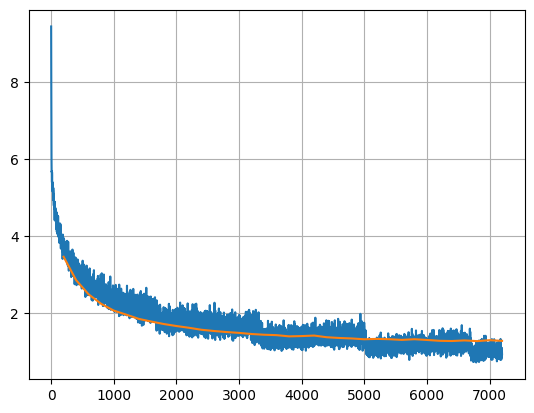

In [24]:
plt.plot([i["step"] for i in record["train"]], [i["loss"] for i in record["train"]], label="train")
plt.plot([i["step"] for i in record["val"]], [i["loss"] for i in record["val"]], label="val")
plt.grid()
plt.show()

# 推理

In [25]:
!ls checkpoints/translate-seq2seq

best.ckpt


In [26]:
# 初始化模型结构（需保持和训练时相同的参数）
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))

# 加载预训练权重（map_location='cpu'表示强制加载到CPU，即使训练时使用GPU）
model.load_state_dict(
    torch.load("./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu")
)


class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        """
        初始化翻译器
        :param model: 加载好权重的seq2seq模型
        :param src_tokenizer: 源语言（输入）的tokenizer
        :param trg_tokenizer: 目标语言（输出）的tokenizer
        """
        self.model = model
        self.model.eval()  # 切换为推理模式（关闭dropout等训练专用层）
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def draw_attention_map(self, scores, src_words_list, trg_words_list):
        """绘制注意力热力图（可视化对齐关系）
        :param scores: 注意力分数矩阵 [源序列长度, 目标序列长度]
        """
        plt.matshow(scores.T, cmap='viridis')  # 转置矩阵使源序列在x轴
        ax = plt.gca()
        
        # 添加数值标注（保留两位小数）
        for i in range(scores.shape[0]):
            for j in range(scores.shape[1]):
                ax.text(j, i, f'{scores[i, j]:.2f}', 
                        ha='center', va='center', color='k')
        
        # 设置坐标标签
        plt.xticks(range(scores.shape[0]), src_words_list, rotation=45)
        plt.yticks(range(scores.shape[1]), trg_words_list)
        plt.show()

    def __call__(self, sentence):
        """完整翻译流程
        :param sentence: 原始输入句子（字符串）
        :return: 翻译结果（字符串）
        """
        # 1. 输入预处理（大小写转换、标点处理等）
        sentence = preprocess_sentence(sentence)
        
        # 2. 编码为模型输入（添加特殊符号，转换为tensor）
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,    # 是否在序列前填充
            add_bos=True,          # 添加起始符
            add_eos=True,          # 添加结束符
            return_mask=True       # 返回注意力掩码（用于处理padding）
        )
        encoder_input = torch.tensor(encoder_input, dtype=torch.int64)
        
        # 3. 模型推理（获取预测结果和注意力分数）
        preds, scores = model.infer(
            encoder_input=encoder_input,
            attn_mask=attn_mask
        )
        
        # 4. 解码为可读文本（移除特殊符号）
        trg_sentence = self.trg_tokenizer.decode(
            [preds], 
            split=True,          # 是否按空格分割单词
            remove_eos=False      # 保留EOS用于后续处理
        )[0]
        
        # 5. 解码源语句用于可视化（保留所有特殊符号）
        src_decoded = self.src_tokenizer.decode(
            encoder_input.tolist(),
            split=True,
            remove_bos=False,
            remove_eos=False
        )[0]
        
        # 6. 可视化注意力机制
        self.draw_attention_map(
            scores.squeeze(0).numpy(),  # 去除batch维度
            src_decoded,                # 源语言词列表
            trg_sentence                # 目标语言词列表
        )
        
        # 7. 返回翻译结果（去除末尾的EOS标记）
        return " ".join(trg_sentence[:-1])


/tmp/ipykernel_599/3052889264.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load("./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu")


/tmp/ipykernel_599/3052889264.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder_input = torch.tensor(encoder_input, dtype=torch.int64)


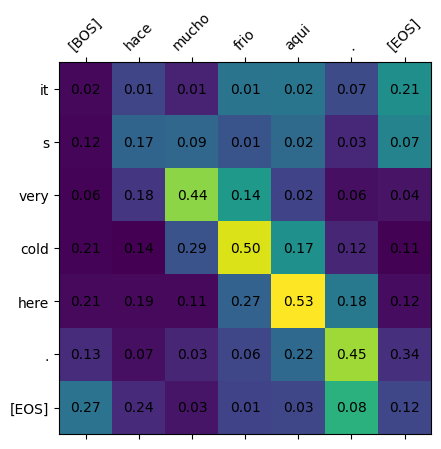

'it s very cold here .'

In [27]:
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)
translator(u'hace mucho frio aqui .')

/tmp/ipykernel_599/3052889264.py:57: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  encoder_input = torch.tensor(encoder_input, dtype=torch.int64)


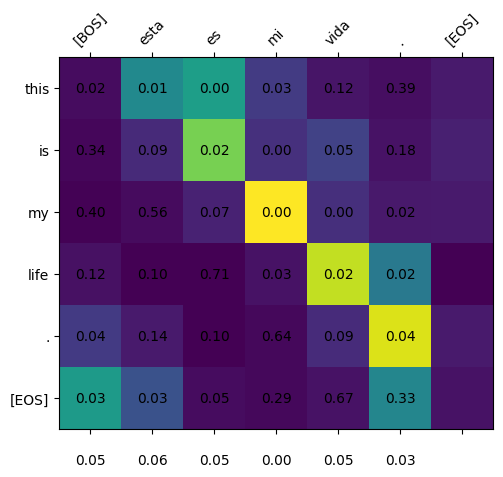

'this is my life .'

In [28]:
translator(u'esta es mi vida.')

In [29]:
# 初始化模型结构
# - src_word2idx: 源语言的词到索引的映射字典
# - trg_word2idx: 目标语言的词到索引的映射字典
# - len(src_word2idx): 源语言的词汇表大小
# - len(trg_word2idx): 目标语言的词汇表大小
model = Sequence2Sequence(len(src_word2idx), len(trg_word2idx))

# 加载预训练模型的权重
# - "./checkpoints/translate-seq2seq/best.ckpt": 模型权重文件的路径
# - map_location="cpu": 将模型权重加载到 CPU 上（即使训练时使用的是 GPU）
model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_location="cpu"))

class Translator:
    def __init__(self, model, src_tokenizer, trg_tokenizer):
        """
        初始化翻译器
        :param model: 加载好权重的 seq2seq 模型
        :param src_tokenizer: 源语言的 tokenizer（用于编码输入句子）
        :param trg_tokenizer: 目标语言的 tokenizer（用于解码输出句子）
        """
        self.model = model
        self.model.eval()  # 将模型设置为评估模式（关闭 dropout 等训练专用层）
        self.src_tokenizer = src_tokenizer
        self.trg_tokenizer = trg_tokenizer

    def __call__(self, sentence):
        """
        翻译句子的核心逻辑
        :param sentence: 输入的源语言句子（字符串）
        :return: 翻译后的目标语言句子（字符串）
        """
        # 1. 预处理输入句子（例如：大小写转换、标点符号处理等）
        sentence = preprocess_sentence(sentence)

        # 2. 使用源语言 tokenizer 对句子进行编码
        # - sentence.split(): 将句子按空格分割成单词列表
        # - padding_first=True: 在序列前面填充（如果需要）
        # - add_bos=True: 添加起始符 <BOS>
        # - add_eos=True: 添加结束符 <EOS>
        # - return_mask=True: 返回注意力掩码（用于处理填充部分）
        encoder_input, attn_mask = self.src_tokenizer.encode(
            [sentence.split()],
            padding_first=True,
            add_bos=True,
            add_eos=True,
            return_mask=True,
        )

        # 3. 将编码后的输入转换为 PyTorch 张量，并指定数据类型为 int64
        encoder_input = torch.Tensor(encoder_input).to(dtype=torch.int64)

        # 4. 使用模型进行推理，获取预测结果和注意力分数
        # - preds: 模型预测的目标语言 token ID 序列
        # - scores: 注意力分数（可选，用于可视化）
        preds, scores = model.infer(encoder_input=encoder_input, attn_mask=attn_mask)

        # 5. 使用目标语言 tokenizer 将预测的 token ID 序列解码为句子
        # - split=True: 按空格分割单词
        # - remove_eos=False: 保留结束符 <EOS>
        trg_sentence = self.trg_tokenizer.decode([preds], split=True, remove_eos=False)[0]

        # 6. 返回翻译结果（去除末尾的 <EOS> 标记）
        return " ".join(trg_sentence[:-1])
    
from nltk.translate.bleu_score import sentence_bleu

def evaluate_bleu_on_test_set(test_data, translator):
    """
    在测试集上计算平均 BLEU 分数。
    :param test_data: 测试集数据，格式为 [(src_sentence, [ref_translation1, ref_translation2, ...]), ...]
    :param translator: 翻译器对象（Translator 类的实例）
    :return: 平均 BLEU 分数
    """
    total_bleu = 0.0  # 用于累加所有句子的 BLEU 分数
    num_samples = len(test_data)  # 测试集的样本数量

    for src_sentence, ref_translations in test_data:
        # 1. 使用翻译器生成候选翻译结果
        candidate_translation = translator(src_sentence)

        # 2. 计算 BLEU 分数
        # - [ref_translations.split()]: 将参考翻译句子分割成单词列表
        # - candidate_translation.split(): 将候选翻译句子分割成单词列表
        # - weights=(1, 0, 0, 0): 仅使用 1-gram 计算 BLEU 分数（可根据需求调整）
        bleu_score = sentence_bleu([ref_translations.split()], candidate_translation.split(), weights=(1, 0, 0, 0))
        total_bleu += bleu_score  # 累加当前句子的 BLEU 分数

        # 3. （可选）打印当前句子的翻译结果和 BLEU 分数
        # print(f"Source: {src_sentence}")
        # print(f"Reference: {ref_translations}")
        # print(f"Candidate: {candidate_translation}")
        # print(f"BLEU: {bleu_score:.4f}")
        # print("-" * 50)

    # 4. 计算平均 BLEU 分数
    avg_bleu = total_bleu / num_samples
    return avg_bleu

# 初始化翻译器
# - model.cpu(): 确保模型在 CPU 上运行
# - src_tokenizer: 源语言的 tokenizer
# - trg_tokenizer: 目标语言的 tokenizer
translator = Translator(model.cpu(), src_tokenizer, trg_tokenizer)

# 在测试集上评估 BLEU 分数
# - test_ds: 测试集数据，格式为 [(src_sentence, ref_translation), ...]
# - translator: 翻译器对象
evaluate_bleu_on_test_set(test_ds, translator)

/tmp/ipykernel_599/4228430312.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"./checkpoints/translate-seq2seq/best.ckpt", map_locatio

0.7002402134357906